In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

In [2]:
data = pd.read_csv("C:/Users/anmol/OneDrive/OneDrive/ドキュメント/internship(Unified)/Personalized Healthcare Recommendation/healthcare_dataset.csv")

In [3]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
data = data.drop_duplicates()

In [5]:
data.shape

(96146, 9)

In [6]:
# Checking for unique values
for i in data.columns:
    unique = len(data[i].unique())
    print("The unique values in column",i,"are", unique)

The unique values in column gender are 3
The unique values in column age are 102
The unique values in column hypertension are 2
The unique values in column heart_disease are 2
The unique values in column smoking_history are 6
The unique values in column bmi are 4247
The unique values in column HbA1c_level are 18
The unique values in column blood_glucose_level are 18
The unique values in column diabetes are 2


In [7]:
# Checking for null values
data.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [8]:
data.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000
mean,41.794326,0.077601,0.040803,27.321461,5.532609,138.218231,0.088220
std,22.462948,0.267544,0.197833,6.767716,1.073232,40.909771,0.283616
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,59.000000,0.000000,0.000000,29.860000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


## Univariate Analysis

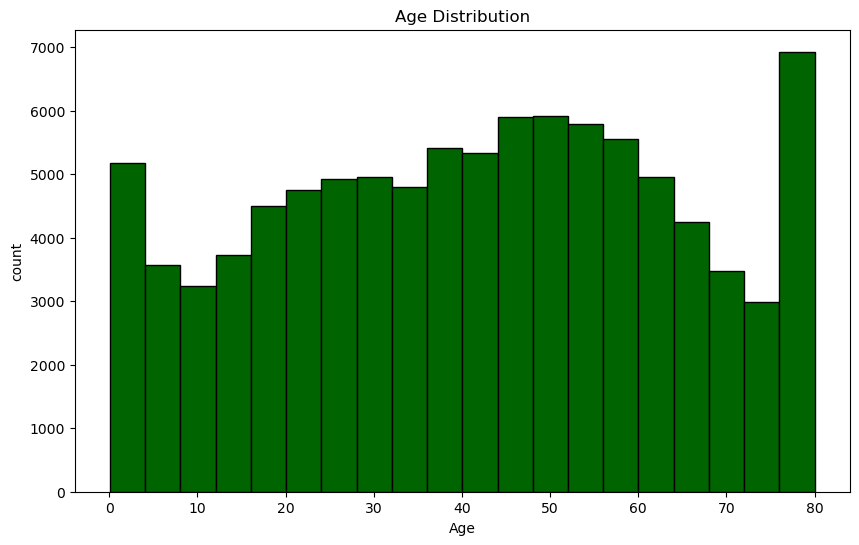

In [9]:
plt.figure(figsize = (10, 6))
plt.hist(data['age'], bins = 20, edgecolor = 'black', color = 'darkgreen')
plt.title ('Age Distribution')
plt.xlabel('Age')
plt.ylabel('count')
plt.show()

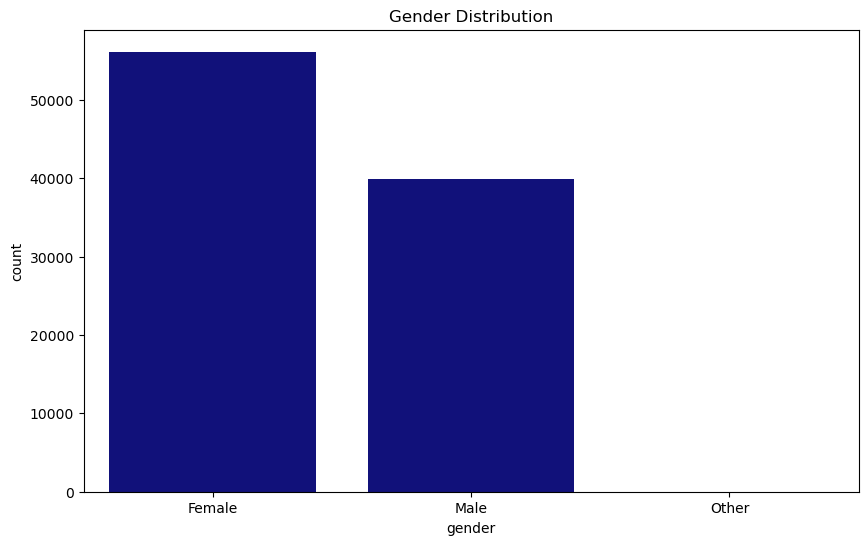

In [10]:
plt.figure(figsize = (10, 6))
sns.countplot(x = 'gender', data = data, color = 'darkblue')
plt.title('Gender Distribution')
plt.show()

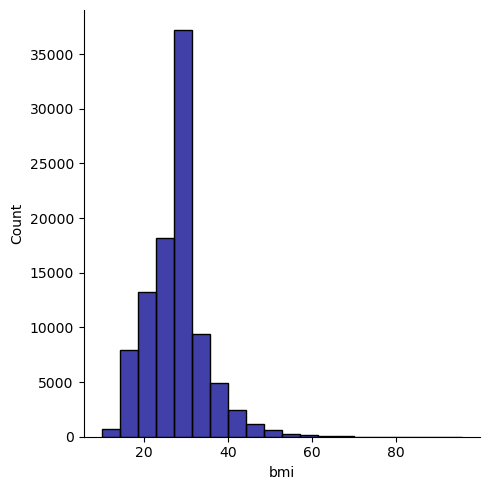

In [11]:
sns.displot(x = 'bmi', data = data, bins = 20, color = 'darkblue')
plt.show()

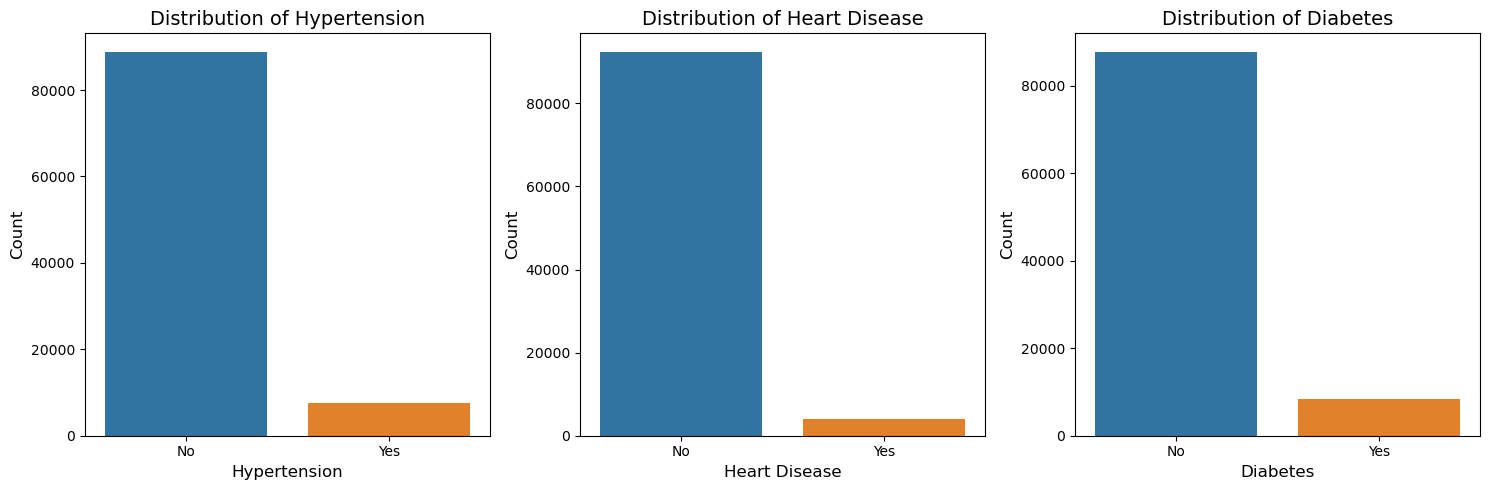

In [12]:
cols = ['hypertension', 'heart_disease', 'diabetes']

fig, axes = plt.subplots(1, len(cols), figsize=(15, 5)) 

for i, col in enumerate(cols):
    sns.countplot(data=data, x=col, hue=col, legend=False, ax=axes[i])  

    axes[i].set_xlabel(col.replace("_", " ").title(), fontsize=12)
    axes[i].set_ylabel("Count", fontsize=12)
    axes[i].set_title(f"Distribution of {col.replace("_", " ").title()}", fontsize=14)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["No", "Yes"])  
plt.tight_layout()  
plt.show()

In [13]:
data['smoking_history'].value_counts()

smoking_history
never          34398
No Info        32887
former          9299
current         9197
not current     6367
ever            3998
Name: count, dtype: int64

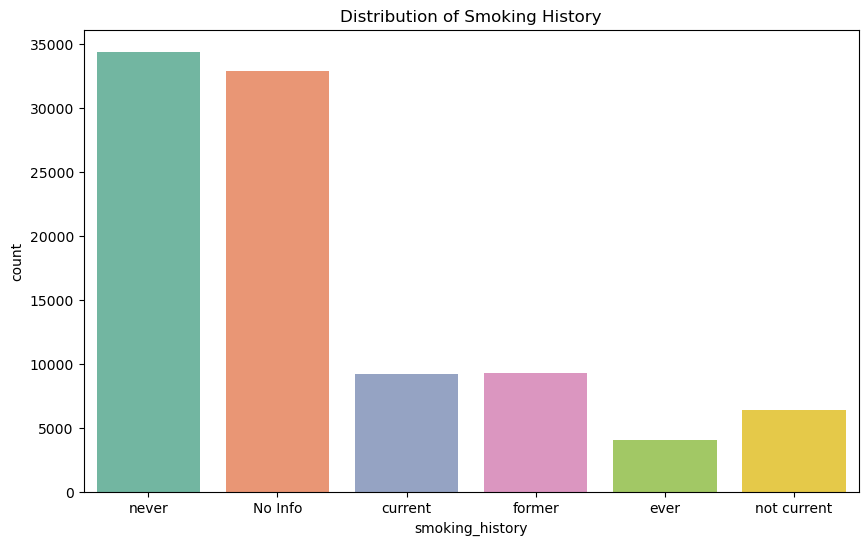

In [14]:
plt.figure(figsize = (10, 6))
sns.countplot(x = 'smoking_history', hue = 'smoking_history', data = data, palette = "Set2")
plt.title("Distribution of Smoking History")
plt.show()

## Bivariate Analysis

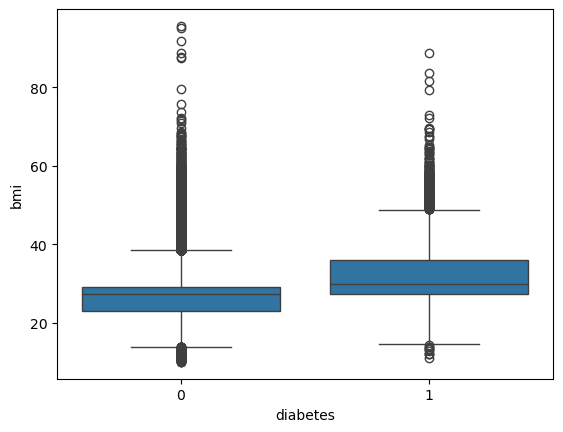

In [15]:
sns.boxplot(x = 'diabetes', y = 'bmi', data = data)
plt.show()

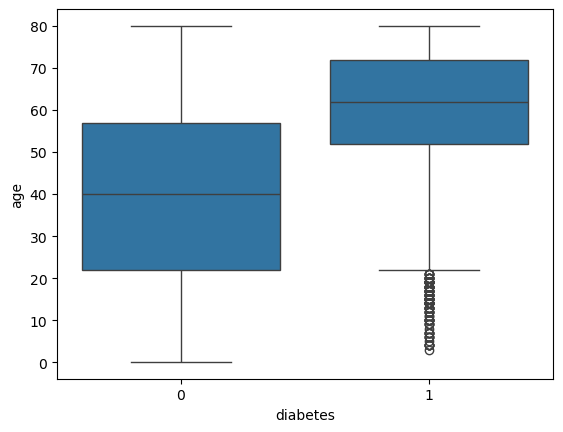

In [16]:
sns.boxplot(x = 'diabetes', y = 'age', data = data)
plt.show()

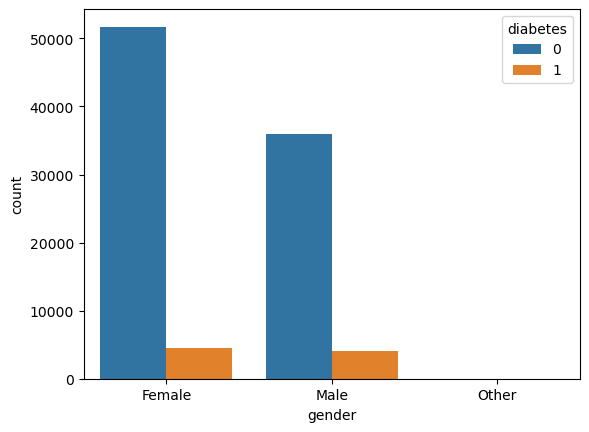

In [17]:
sns.countplot(x = 'gender', hue = 'diabetes', data = data)
plt.show()

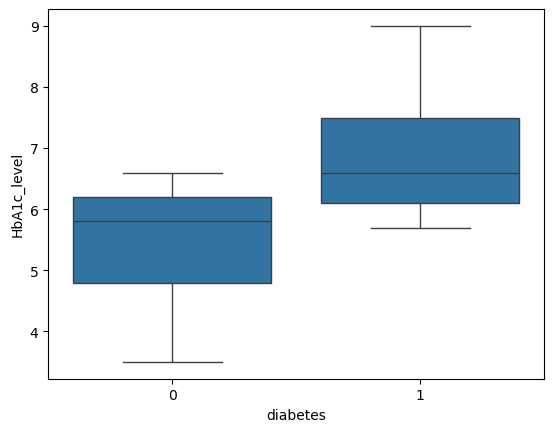

In [18]:
sns.boxplot(x = 'diabetes', y = 'HbA1c_level', data = data)
plt.show()

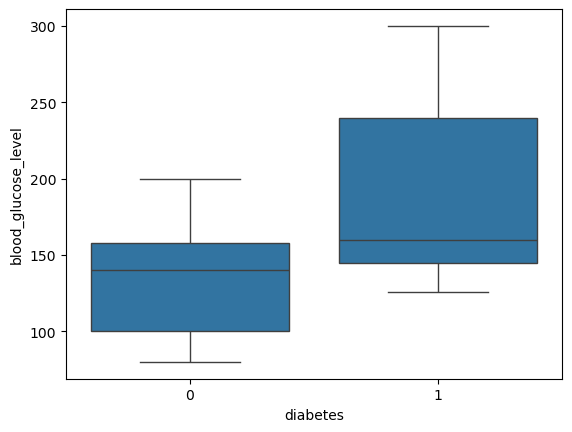

In [19]:
sns.boxplot(x = 'diabetes', y = 'blood_glucose_level', data = data)
plt.show()

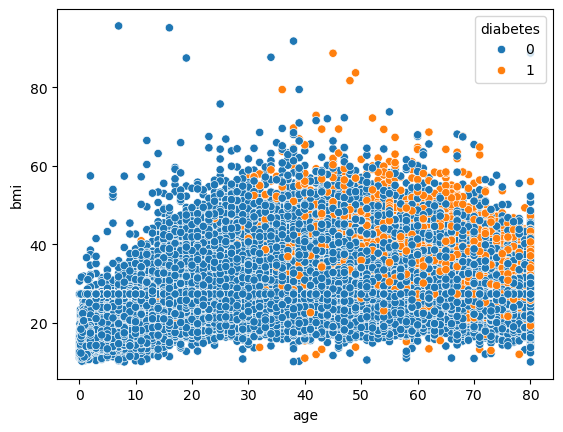

In [20]:
sns.scatterplot(x = 'age', y = 'bmi', hue = 'diabetes', data = data)
plt.show()

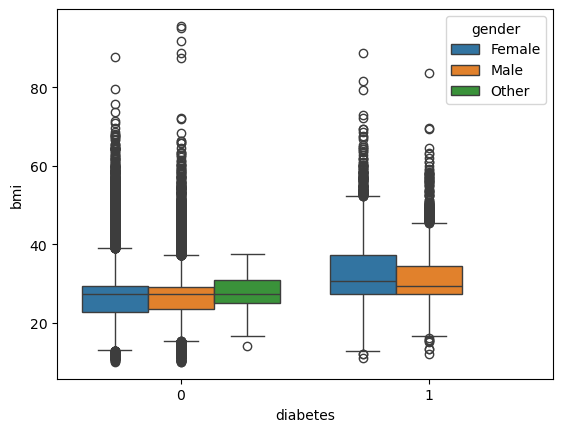

In [21]:
sns.boxplot(x = 'diabetes', y ='bmi', hue = 'gender', data = data)
plt.show()

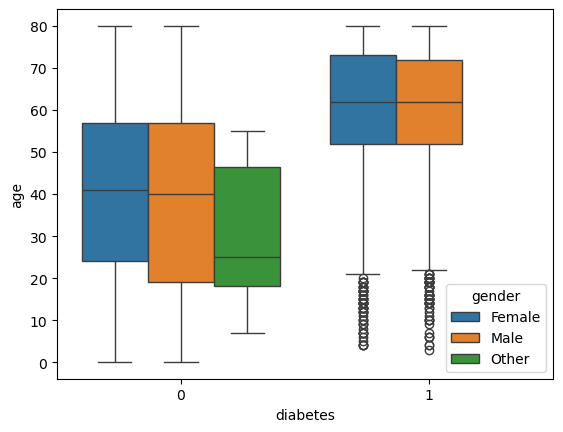

In [22]:
sns.boxplot(x = 'diabetes', y ='age', hue = 'gender', data = data)
plt.show()

In [23]:
data.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')

In [24]:
data['smoking_history'].unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

In [25]:
def recategorize_smoking(smoking_history_val):
    if smoking_history_val in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_history_val in ['current']:
        return 'current'
    elif smoking_history_val in ['former', 'ever', 'not_current']:
        return 'past-smoker'

data['smoking_history'] = data['smoking_history'].apply(recategorize_smoking)

In [26]:
data['smoking_history'].value_counts()

smoking_history
non-smoker     67285
past-smoker    13297
current         9197
Name: count, dtype: int64

In [27]:
data = data.copy()

In [28]:
def one_hot_encode_df(data, columns_to_encode):
    df_encoded = pd.get_dummies(data, columns = columns_to_encode)
    return df_encoded

columns_to_encode = ['gender', 'smoking_history']
encoded_df = one_hot_encode_df(data, columns_to_encode)

print(encoded_df)

        age  hypertension  heart_disease    bmi  HbA1c_level  \
0      80.0             0              1  25.19          6.6   
1      54.0             0              0  27.32          6.6   
2      28.0             0              0  27.32          5.7   
3      36.0             0              0  23.45          5.0   
4      76.0             1              1  20.14          4.8   
...     ...           ...            ...    ...          ...   
99994  36.0             0              0  24.60          4.8   
99996   2.0             0              0  17.37          6.5   
99997  66.0             0              0  27.83          5.7   
99998  24.0             0              0  35.42          4.0   
99999  57.0             0              0  22.43          6.6   

       blood_glucose_level  diabetes  gender_Female  gender_Male  \
0                      140         0           True        False   
1                       80         0           True        False   
2                      158 

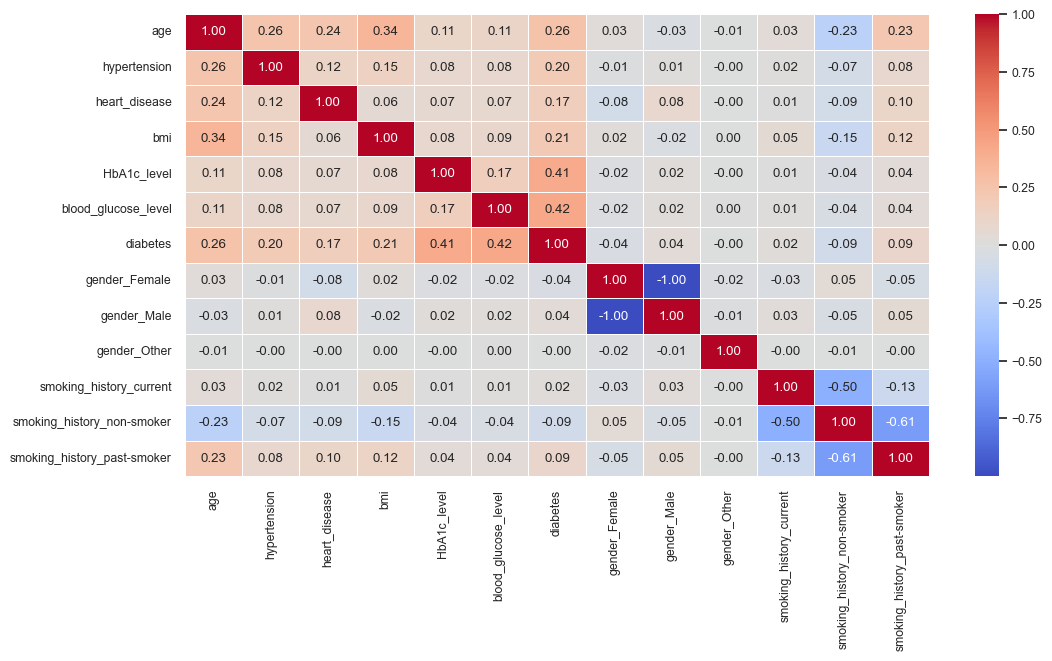

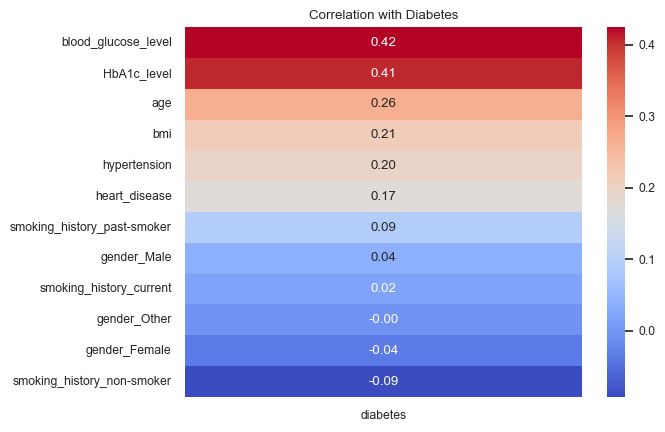

In [30]:
correlation_matrix = encoded_df.corr()

plt.figure(figsize = (12,6))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', linewidths = 0.5, fmt = '0.2f')
plt.show()

corr = encoded_df.corr()
target_corr = corr['diabetes'].drop('diabetes')
target_corr_sorted = target_corr.sort_values(ascending = False)
sns.set(font_scale = 0.8)
sns.set_style('white')
sns.set_palette('PuBuGn_d')
sns.heatmap(target_corr_sorted.to_frame(), cmap = 'coolwarm', annot = True, fmt = '0.2f')
plt.title('Correlation with Diabetes')
plt.show()

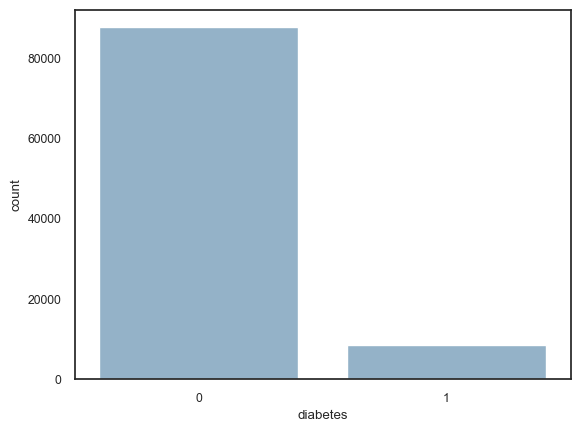

In [31]:
sns.countplot(x = 'diabetes', data = data)
plt.show()

In [32]:
over = SMOTE(sampling_strategy = 0.1)
under = RandomUnderSampler(sampling_strategy = 0.5)

In [33]:
preprocessor = ColumnTransformer(transformers = [
    ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease']),
    ('cat', OneHotEncoder(handle_unknown = 'ignore'), ['gender', 'smoking_history'])
])

x = data.drop('diabetes', axis = 1)
y = data['diabetes']

In [34]:
classifier = imbPipeline(steps = [
    ('preprocessor', preprocessor),
    ('over', over),
    ('under', under), 
    ('classifier', RandomForestClassifier(random_state = 42))
])

## Hyperparameter Tuning

In [35]:
parameters = {
    'classifier__n_estimators': [100, 150, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [36]:
rf_model = RandomizedSearchCV(classifier, parameters, cv = 5)

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
rf_model.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'bmi',
                                                                                'HbA1c_level',
                                                                                'blood_glucose_level',
                                                                                'hypertension',
                                                                                'heart_disease']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['gender',
                                                                                'smoking_history'])])),
                                             ('over',
                                              SMOTE(sampling_strategy=0.1)),
                                             ('under',
                                              RandomUnderSampler(sampling_strategy=0.5)),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'classifier__max_depth': [None, 10, 20],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [100, 150,
                                                                     200]})

In [39]:
print('Best_parameters:', rf_model.best_params_)

Best_parameters: {'classifier__n_estimators': 150, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 10}


## Random Forest Classifier

Random Forest Classifier:

Accuracy score: 0.9527301092043682

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97     17509
           1       0.71      0.81      0.75      1721

    accuracy                           0.95     19230
   macro avg       0.84      0.89      0.86     19230
weighted avg       0.96      0.95      0.95     19230




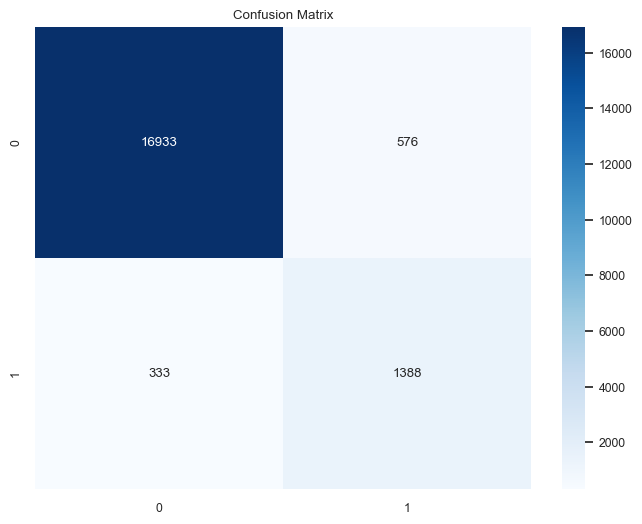

In [40]:
print("Random Forest Classifier:\n")

y_pred = rf_model.predict(x_test)

print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print(f'\nClassification report:\n {classification_report(y_test, y_pred)}\n')

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8, 6))
plt.title('Confusion Matrix')
sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = 'g')

plt.show()

## Feature Importances

                        Feature  Importance
2                   HbA1c_level    0.436935
3           blood_glucose_level    0.304791
0                           age    0.127311
1                           bmi    0.067309
4                  hypertension    0.032058
5                 heart_disease    0.017806
10   smoking_history_non-smoker    0.004391
11  smoking_history_past-smoker    0.003516
6                 gender_Female    0.002162
7                   gender_Male    0.001995
9       smoking_history_current    0.000977
12         smoking_history_None    0.000739
8                  gender_Other    0.000010 





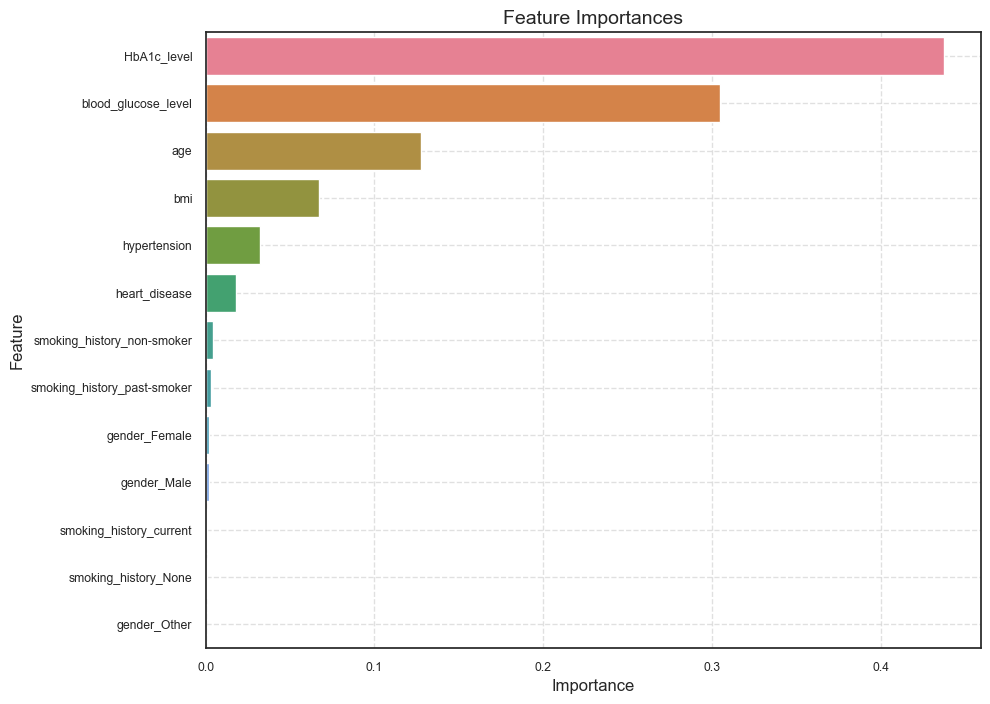

In [43]:
onehot_columns = list(rf_model.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['gender', 'smoking_history']))

feature_names = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease'] + onehot_columns

importances = rf_model.best_estimator_.named_steps['classifier'].feature_importances_

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

importance_df = importance_df.sort_values(by = 'Importance', ascending = False)
print(importance_df,"\n\n\n")

plt.figure(figsize=(10, 8))
sns.barplot(x = 'Importance', y = 'Feature', data = importance_df, hue = 'Feature')

plt.title('Feature Importances', fontsize = 14)
plt.xlabel('Importance', fontsize = 12)
plt.ylabel('Feature', fontsize = 12)
plt.grid(True, linestyle = '--', alpha = 0.6) 

plt.show()


## Neural Networks

In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [41]:
x_transformed = preprocessor.fit_transform(x)  
x_train, x_test, y_train, y_test = train_test_split(x_transformed, y, test_size=0.2, random_state=42)

In [46]:
n_model = Sequential([
    keras.layers.Input(shape=(x_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') 
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
nn_model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/50
2404/2404 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9429 - loss: 0.1635 - val_accuracy: 0.9648 - val_loss: 0.0994
Epoch 2/50
2404/2404 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9651 - loss: 0.1020 - val_accuracy: 0.9660 - val_loss: 0.0952
Epoch 3/50
2404/2404 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9667 - loss: 0.0965 - val_accuracy: 0.9695 - val_loss: 0.0872
Epoch 4/50
2404/2404 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9690 - loss: 0.0900 - val_accuracy: 0.9703 - val_loss: 0.0857
Epoch 5/50
2404/2404 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9685 - loss: 0.0904 - val_accuracy: 0.9697 - val_loss: 0.0866
Epoch 6/50
2404/2404 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9695 - loss: 0.0881 - val_accuracy: 0.9703 - val_loss: 0.0860
Epoch 7/50
2404/2404 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9699 - loss: 0.0874 - val_accuracy: 0.9701 - val_loss: 0.0867
Epoch 8/50
2404/2404 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9693 - loss: 0.0875 - 

In [52]:
y_pred_nn = (nn_model.predict(x_test) > 0.5).astype(int)
print("\nNeural Network Accuracy:", accuracy_score(y_test, y_pred_nn))
print("\nClassification Report (NN):\n", classification_report(y_test, y_pred_nn))

601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step

Neural Network Accuracy: 0.9703068122724909

Classification Report (NN):
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     17509
           1       0.99      0.67      0.80      1721

    accuracy                           0.97     19230
   macro avg       0.98      0.84      0.89     19230
weighted avg       0.97      0.97      0.97     19230



## Gradient Boosting Machines

In [58]:
import xgboost as xgb

In [59]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [60]:
y_pred_xgb = xgb_model.predict(x_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report (XGBoost):\n", classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.9695787831513261
Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     17509
           1       0.96      0.69      0.80      1721

    accuracy                           0.97     19230
   macro avg       0.96      0.84      0.89     19230
weighted avg       0.97      0.97      0.97     19230



## Decision Tree

In [61]:
from sklearn.tree import DecisionTreeClassifier

In [63]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

In [65]:
y_pred_dt = dt_model.predict(x_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Classification Report (Decision Tree):\n", classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.9511700468018721
Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     17509
           1       0.72      0.74      0.73      1721

    accuracy                           0.95     19230
   macro avg       0.85      0.86      0.85     19230
weighted avg       0.95      0.95      0.95     19230



## Logistic regression

In [66]:
from sklearn.linear_model import LogisticRegression

In [70]:
lr_model = LogisticRegression()
lr_model.fit(x_train, y_train)

LogisticRegression()

In [72]:
y_pred_lr = lr_model.predict(x_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report (Logistic Regression):\n", classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.9566822672906916
Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     17509
           1       0.85      0.63      0.72      1721

    accuracy                           0.96     19230
   macro avg       0.91      0.81      0.85     19230
weighted avg       0.95      0.96      0.95     19230

